# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [10]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import h5py
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "/disk/scratch/s1668298/logs"

# Seed a random number generator
SEED = 10102016 
RNG = np.random.RandomState(SEED)

# Dataset root dir
DATASET_DIR = os.path.join(ROOT_DIR, "../indoorScenes/")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [20]:
class IndoorScenesConfig(Config):
    """Configuration for training on the toy indoorScenes dataset.
    Derives from the base Config class and overrides values specific
    to the toy indoorScenes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "indoorScenes"
    
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 object classes (mug, stapler, banana)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128 #32?

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100 #?

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10 #?
    
    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    
    
config = IndoorScenesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [21]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [22]:
class IndoorScenesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_indoorScenes(self, dataset_dir, subset):
        """Load a subset of the indoorScenes dataset.
    
        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes
        self.add_class("indoorScenes", 1, "stapler")
        self.add_class("indoorScenes", 2, "mug")
        self.add_class("indoorScenes", 3, "banana")
        
        assert subset in ["train", "val", "test"]
        gt_data_dir = os.path.join(dataset_dir, "multi_v7")
        img_dir = os.path.join(gt_data_dir, "images")
        
        dataset_size = len([name for name in os.listdir(img_dir)]) - 11
        train_size = int(dataset_size * 0.8)
        val_size = int(dataset_size * 0.1)
        test_size = dataset_size - train_size - val_size
        perm_img_ids = np.array(RNG.permutation(range(1, dataset_size + 1)))
        
        if subset == "train":
            image_ids = perm_img_ids[list(range(train_size))]
        elif subset == "val":
            image_ids = perm_img_ids[list(range(train_size, train_size + val_size))]
        else:
            image_ids = perm_img_ids[list(range(train_size + val_size, dataset_size))]
        
        # Extract object GT values
        f = os.path.join(gt_data_dir, "groundTruthObjects.h5")
        d = h5py.File(f, "r")['multi']
        d = np.stack([d['gtID'], d['gtClass']], axis=-1)
        

        # Add images
        for image_id in image_ids:
            classes = d[d[:, 0] == image_id][:, 1]
            self.add_image(
                "indoorScenes",
                image_id=image_id,
                classes=classes,
                path=os.path.join(img_dir, "im{0}.jpeg".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
            masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        
        # Extract image info
        info = self.image_info[image_id]
        classes = info['classes']
        num_objs = len(classes)
        
        # Load rgb mask
        f = "maskAll{0}.png".format(image_id)
        rgb_mask = skimage.io.imread(os.path.join(DATASET_DIR, "GTmasks", f))
        r_mask = rgb_mask[:, :, 0] // 20 # object i has pixel brightness 20*i
        
        # combined masks --> ordered binary masks (by object instance ID)
        mask = []
        for i in range(1, num_objs + 1):
            obj_mask = (r_mask == i) # object i has pixel brightness i
            mask.append(obj_mask)
        mask = np.stack(mask, axis=-1)
        
        # Return mask, and array of class IDs of each instance
        return mask, classes

    def image_reference(self, image_id):
        """Return the path the image."""
        info = self.image_info[image_id]
        if info["source"] == "indoorScenes":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [23]:
# Training dataset
dataset_train = IndoorScenesDataset()
dataset_train.load_indoorScenes(DATASET_DIR, "train")
dataset_train.prepare()
print(dataset_train.class_names)

# Validation dataset
dataset_val = IndoorScenesDataset()
dataset_val.load_indoorScenes(DATASET_DIR, "val")
dataset_val.prepare()
print(dataset_val.class_names)

['BG', 'stapler', 'mug', 'banana']
['BG', 'stapler', 'mug', 'banana']


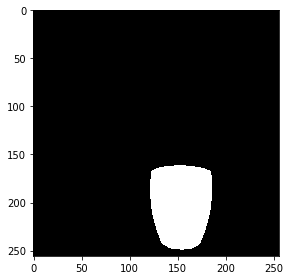

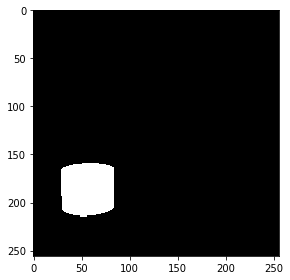

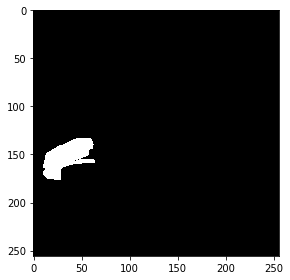

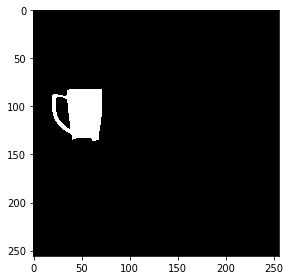

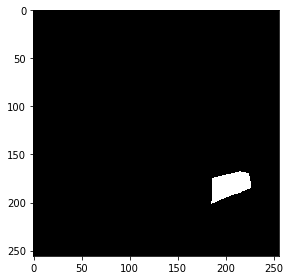

In [13]:
# Load and display masks of a single image
image_id = 5
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
masks = [mask[:, :, i] for i in range(5)]
for m in masks:
    skimage.io.imshow(m)
    plt.show()

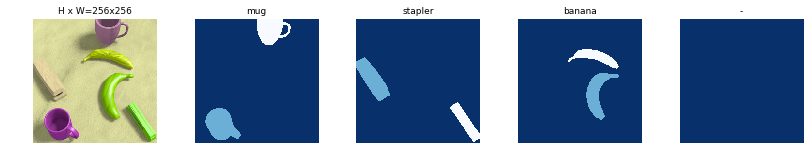

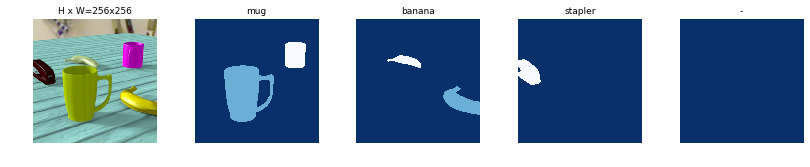

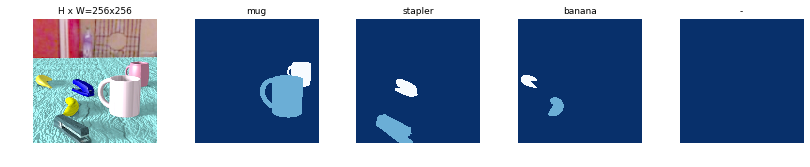

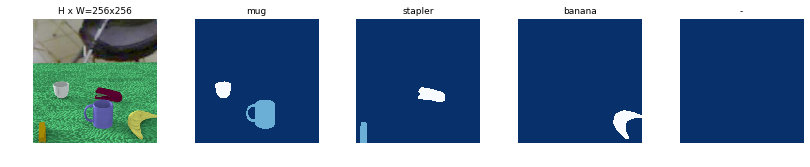

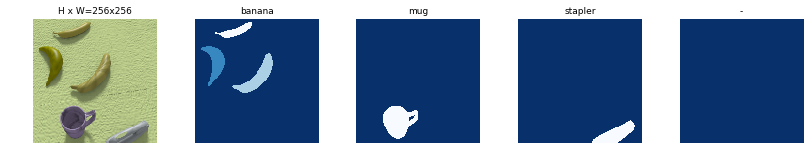

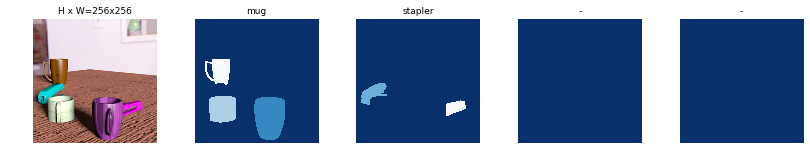

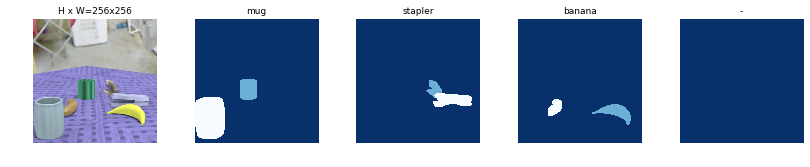

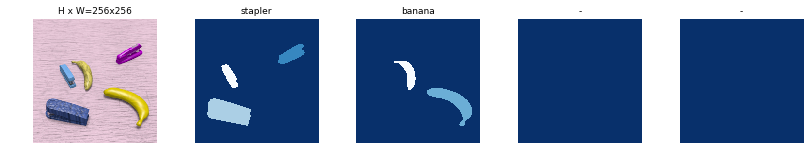

In [53]:
# Load and display random samples
image_ids = range(8)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [24]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [25]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [26]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /disk/scratch/s1668298/logs/indoorscenes20190212T1823/mask_rcnn_indoorscenes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

In [27]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 5. LR=0.0001

Checkpoint Path: /disk/scratch/s1668298/logs/indoorscenes20190212T1823/mask_rcnn_indoorscenes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)7

## Detection

In [41]:
class InferenceConfig(IndoorScenesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /afs/inf.ed.ac.uk/user/s16/s1668298/gof/Mask_RCNN/logs/indoorscenes20190212T1208/mask_rcnn_indoorscenes_0002.h5
Re-starting from epoch 2


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  461.00000  int64
gt_class_id              shape: (5,)                  min:    1.00000  max:    3.00000  uint64
gt_bbox                  shape: (5, 4)                min:   15.00000  max:  254.00000  int32
gt_mask                  shape: (256, 256, 5)         min:    0.00000  max:    1.00000  bool


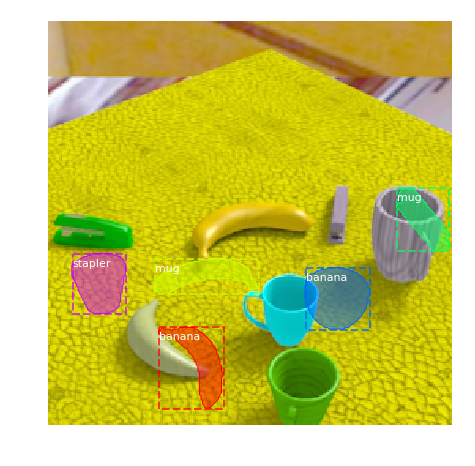

In [42]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


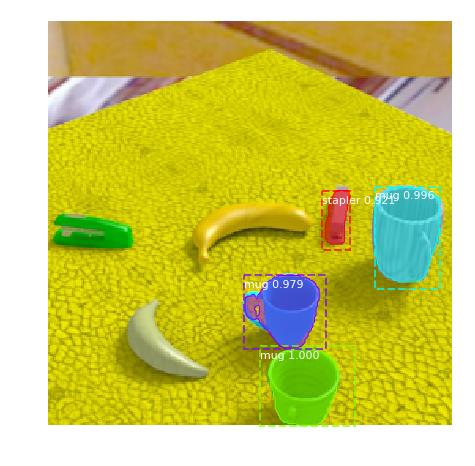

In [43]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [45]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0015000000223517418
